# Fitting Signal Detection Measures to ROC Curves

In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from sklearn.utils import check_consistent_length
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Main Functions
[1] Robert R. Sokal and F. James Rohlf. Biometry: The Principles and Practices of Statistics in BiologicalResearch. W.H. Freeman, 3 edition, 1994  
[2] Hoey, J. (2012). The Two-Way Likelihood Ratio (G) Test and Comparison to Two-Way Chi Squared Test.

In [2]:
def compute_dprime(tp, fp):
    # untested
    return stats.norm.ppf(tp) - stats.norm.ppf(fp)

def compute_c_bias(tp, fp):
    # untested
    return - 0.5 * (stats.norm.ppf(tp) + stats.norm.ppf(fp))

def accumulate(*arrays):
    # untested
    out = []
    for a in arrays:
        accumulated = np.cumsum(a)
        out.append(accumulated)
    return out

def to_freq(*arrays):
    # untested
    out = []
    for a in arrays:
        converted = np.array([(x + i / len(a)) / (max(a)+1) for i, x in enumerate(a, start=1)])
        out.append(converted)
    return out

def convert_to_roc(a, b):
    # untested
    a_c, b_c = accumulate(a, b)
    a_f, b_f = to_freq(a_c, b_c)
    return a_f, b_f

def g_test(x, x_freq, expected, x_max):
    # untested
    # Refs: [1, 2]
    # Two-way log-likelihood G-test
    # Implementation issues:
    #    depending on minimization starting variables, the log expressions can throw errors from negative values and div/0 etc. Numpy just warns and continues.
    a = 2 * x * np.log(x_freq / expected) 
    b = 2 * (x_max - x) * np.log((1 - x_freq) / (1 - expected))
    return a + b

def threshold_model_expectation(R, noise_frequency):
    # untested
    # Get the expected values for signals and noises
    expected_signal = ((1 - R) * noise_frequency + R)[:-1]
    expected_noise = noise_frequency[:-1]
    return expected_signal, expected_noise

def signal_detection_model_expectation(d, c):
    # untested
    expected_signal = stats.norm.cdf(d / 2 - c)
    expected_noise = stats.norm.cdf(-d / 2 - c)
    return expected_signal, expected_noise

def dual_process_model_expectation(R, d, c):
    # untested
    expected_signal = R + (1 - R) * stats.norm.cdf(d / 2 - c)
    expected_noise = stats.norm.cdf(-d / 2 - c)
    return expected_signal, expected_noise

def detection_model(parameters, labels, signal, noise, model='sdt', optimizing=False):
    # untested
    # model options: 'threshold', 'sdt', 'dpsdt', 'thresh'
    
    # Implementation issues:
    #    parameters and labels are specified as separate ndarrays arrays because of how the optimizer works. Maybe this can be improved?
    
    #------------------------- Check Inputs ---------------------------#
    # Ensure equal length
    check_consistent_length(signal, noise)
    check_consistent_length(parameters, labels)
    
    # Accumulate (c) the signal and noise data
    signal_c, noise_c = accumulate(signal, noise) # np.cumsum(signal), np.cumsum(noise)
    # Get frequencies for the cumulative signal and noise
    signal_f, noise_f = to_freq(signal_c, noise_c)
    
    #------------------------- Model Specific -------------------------#
    if model == 'sdt':
        if 'd' not in labels:
            raise ValueError(f"Either or both of `R` and `d` not specified in parameter labels. labels specified were: {labels}.")
        d = parameters[labels == 'd'].item()
        c = parameters[(labels!='R') & (labels!='d')] # Can c_values be 0? what about 1?
        exp_signal, exp_noise = signal_detection_model_expectation(d, c)
        
    elif model == 'dpsdt':
        if ('R' not in labels) or ('d' not in labels):
            raise ValueError(f"Either or both of `R` and `d` not specified in parameter labels. labels specified were: {labels}.")
        # Grab the R and d values
        R = parameters[labels == 'R'].item()
        d = parameters[labels == 'd'].item()
    
        c = parameters[(labels!='R') & (labels!='d')] # Can c_values be 0? what about 1?
        # Get the expected values for signals and noises
        exp_signal, exp_noise = dual_process_model_expectation(R, d, c)
    
    elif model == 'thresh':
        if ('R' not in labels):
            raise ValueError(f"Either or both of `R` and `d` not specified in parameter labels. labels specified were: {labels}.")
        R = parameters[labels == 'R'].item()
        exp_signal, exp_noise = threshold_model_expectation(R, noise_f)
    #------------------------------------------------------------------#

    # Compute the gsquared using the dual process model parameters
    #   Still getting runtime warnings about division. Function only works with numpy, so can't use math.
    signal_gsquared = g_test(x=signal_c[:-1], x_freq=signal_f[:-1], expected=exp_signal, x_max=signal_c.max())
    noise_gsquared = g_test(x=noise_c[:-1], x_freq=noise_f[:-1], expected=exp_noise, x_max=noise_c.max())
    
    g_squared_summed = np.sum([signal_gsquared, noise_gsquared])
    
    if optimizing:
        return g_squared_summed
    else:
        return g_squared_summed, exp_signal, exp_noise


def optimize_model(objective, labels, signal, noise, model, iterations=25, parameters=None, verbose=True):
    for i in range(iterations):
        try:
            if not parameters:
                # Random parameter initialization (default)
                parameters = np.random.uniform(-.5, .5, len(labels))
                optimizing = True # must set in order to return just the objective function
                
            opt = minimize(fun=objective, x0=parameters, args=(labels, signal, noise, model, optimizing), tol=1e-4)
            if opt.success:
                # Converged at (local?) minimum.
                if verbose==True:
                    print(opt)
                else:
                    print("Optimisation successful\n")
                break
            else:
                raise ValueError("Optimisation unsuccessful")
        except:
            opt = None
    return opt

## Testing the different models with example data

In [3]:
# Example data
signal = [508,224,172,135,119,63] # Signal present examples
noise = [102,161,288,472,492,308] # Signal absent examples

### 1.1. signal detection model

In [5]:
# Arguments
# Parameters randomly set in the fit_model function
parameters = np.array([1.12279662339189, 0.871166834070118, 0.405779553457989, -0.0588639712751784, -0.644343940682155, -1.42214656169388])
labels = np.array(['d', 'c1', 'c2', 'c3', 'c4', 'c5'])
expected = 91.8424069319085

model_fit, s, n = detection_model(parameters=parameters, labels=labels, signal=signal, noise=noise, model='sdt')

np.allclose(model_fit, expected)
print(f"expected G\N{SUPERSCRIPT TWO}: {expected}\nfound G\N{SUPERSCRIPT TWO}:{model_fit}")

expected G²: 91.8424069319085
found G²:91.84240693190836


#### 1.2. Optimizing signal detection model

In [6]:
opt = optimize_model(objective=detection_model, labels=labels, signal=signal, noise=noise,model='sdt')

if opt:
    if opt.success:
        optimal_sdt_parameters = {l:v for l, v in zip(labels, opt.x)}
        print(f"optimal parameters found:\n{optimal_sdt_parameters}")
        sdt_g, sdt_signal, sdt_noise = detection_model(parameters=parameters, labels=labels, signal=signal, noise=noise, model='sdt')
else:
    print("Failure.")

      fun: 91.84240692669376
 hess_inv: array([[ 3.02293159e-04,  3.84966299e-05,  2.96731286e-08,
        -3.34163267e-05, -6.06135146e-05, -8.53390508e-05],
       [ 3.84966299e-05,  3.70744922e-04,  2.83875775e-06,
        -6.58109382e-06, -1.38181927e-05, -3.68370368e-05],
       [ 2.96731286e-08,  2.83875775e-06,  3.12073015e-04,
         3.04808417e-06, -2.16095631e-06,  1.05495581e-05],
       [-3.34163267e-05, -6.58109382e-06,  3.04808417e-06,
         2.78581108e-04,  4.78553412e-06,  3.56048243e-06],
       [-6.06135146e-05, -1.38181927e-05, -2.16095631e-06,
         4.78553412e-06,  3.04307007e-04,  1.28404619e-05],
       [-8.53390508e-05, -3.68370368e-05,  1.05495581e-05,
         3.56048243e-06,  1.28404619e-05,  4.47163975e-04]])
      jac: array([-2.28881836e-05,  3.05175781e-05, -4.67300415e-05,  4.38690186e-05,
        2.38418579e-05,  4.86373901e-05])
  message: 'Optimization terminated successfully.'
     nfev: 200
      nit: 15
     njev: 25
   status: 0
  success:

### 2.1. dual process model

In [7]:
parameters = np.array([0.329619769943936, 0.669264105874664, 1.30349820023126, 0.683947212600267, 0.145604921894773, -0.473844533479801, -1.25079084398587])
labels = np.array(['R', 'd', 'c1', 'c2', 'c3', 'c4', 'c5'])
expected = 22.6109004733713

model_fit, s, n = detection_model(parameters=parameters, labels=labels, signal=signal, noise=noise, model='dpsdt')

np.allclose(model_fit, expected)
print(f"expected G\N{SUPERSCRIPT TWO}: {expected}\nfound G\N{SUPERSCRIPT TWO}:{model_fit}")

expected G²: 22.6109004733713
found G²:22.61090047337164


#### 2.2. Optimizing dual-process model

In [16]:
opt = optimize_model(objective=detection_model, labels=labels, signal=signal, noise=noise, iterations=500, model='dpsdt')

if opt:
    if opt.success:
        optimal_dpsdt_parameters = {l:v for l, v in zip(labels, opt.x)}
        print(f"optimal parameters found:\n{optimal_dpsdt_parameters}")
        
else:
    print("Failure.")

      fun: 22.61090046759457
 hess_inv: array([[ 0.00033465, -0.00062081,  0.00052302,  0.00040708,  0.00030935,
         0.00024754,  0.00020713],
       [-0.00062081,  0.00161792, -0.00108465, -0.00086295, -0.00068359,
        -0.00057715, -0.00050631],
       [ 0.00052302, -0.00108465,  0.00170636,  0.00067336,  0.00052251,
         0.00042086,  0.00034271],
       [ 0.00040708, -0.00086295,  0.00067336,  0.00100341,  0.00040004,
         0.00032856,  0.00027117],
       [ 0.00030935, -0.00068359,  0.00052251,  0.00040004,  0.00064499,
         0.00025375,  0.00023109],
       [ 0.00024754, -0.00057715,  0.00042086,  0.00032856,  0.00025375,
         0.00053583,  0.00018874],
       [ 0.00020713, -0.00050631,  0.00034271,  0.00027117,  0.00023109,
         0.00018874,  0.00062673]])
      jac: array([-6.65187836e-05, -1.14440918e-05, -4.76837158e-07,  4.38690186e-05,
        3.81469727e-06, -1.16825104e-05, -8.58306885e-06])
  message: 'Optimization terminated successfully.'
     nf

### 3.1. threshold model

In [17]:
parameters = np.array([0.520274590415736])
labels = np.array(['R'])
expected = 163.275256078908
model_fit, s, n = detection_model(parameters=parameters, labels=labels, signal=signal, noise=noise, model='thresh')

np.allclose(model_fit, expected)
print(f"expected G\N{SUPERSCRIPT TWO}: {expected}\nfound G\N{SUPERSCRIPT TWO}:{model_fit}")

expected G²: 163.275256078908
found G²:163.27525607890783


#### 3.2. Optimizing threshold model

This one gives errors and needs more work. It does work if you run it enough times.

In [46]:
opt = optimize_model(objective=detection_model, labels=labels, signal=signal, noise=noise, model='thresh')

if opt:
    if opt.success:
        optimal_threshold_parameters = {l:v for l, v in zip(labels, opt.x)}
        print(f"optimal parameters found:\n{optimal_threshold_parameters}")
else:
    print("Failure.")

      fun: 163.27525607888924
 hess_inv: array([[4.13964449e-05]])
      jac: array([-6.86645508e-05])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([0.52027462])
optimal parameters found:
{'R': 0.5202746213906495}


# Plotting

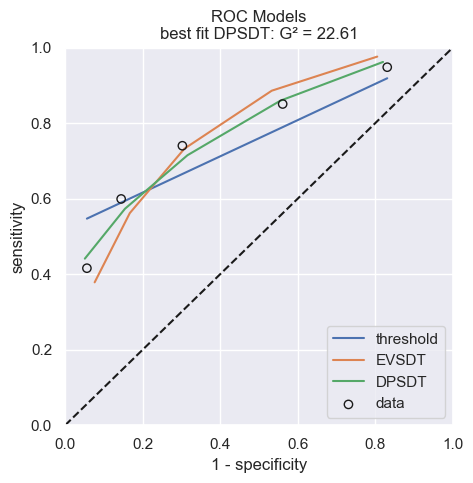

In [47]:
sdt_g, sdt_signal, sdt_noise = detection_model(parameters=np.array(list(optimal_sdt_parameters.values())),
                                               labels=np.array(list(optimal_sdt_parameters.keys())),
                                               signal=signal,
                                               noise=noise,
                                               model='sdt')

dpsdt_g, dpsdt_signal, dpsdt_noise = detection_model(parameters=np.array(list(optimal_dpsdt_parameters.values())),
                                                     labels=np.array(list(optimal_dpsdt_parameters.keys())),
                                                     signal=signal,
                                                     noise=noise,
                                                     model='dpsdt')

threshold_g, threshold_signal, threshold_noise = detection_model(parameters=np.array(list(optimal_threshold_parameters.values())),
                                                                 labels=np.array(list(optimal_threshold_parameters.keys())),
                                                                 signal=signal,
                                                                 noise=noise,
                                                                 model='thresh')

performances = {'SDT':sdt_g, 'DPSDT':dpsdt_g, 'threshold':threshold_g}

# Find best fit
best_fit_g = performances[min(performances)]
best_fit_model = min(performances, key=performances.get)

fig, ax = plt.subplots(figsize=(5,5),dpi=100)
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.plot([0,1],[0,1], c='k',ls='dashed')

# Plot the models
ax.plot(threshold_noise, threshold_signal, label='threshold')
ax.plot(sdt_noise, sdt_signal, label='EVSDT')
ax.plot(dpsdt_noise, dpsdt_signal, label='DPSDT')

# Plot the data
roc_signal, roc_noise = convert_to_roc(signal, noise)
ax.scatter(roc_noise[:-1], roc_signal[:-1], facecolors='none', edgecolors='k', label='data', zorder=10)

ax.set_xlabel('1 - specificity')
ax.set_ylabel('sensitivity')

ax.set_title(f"ROC Models\nbest fit {best_fit_model}: G\N{SUPERSCRIPT TWO} = {best_fit_g:.2f}")
ax.legend()
plt.show()